### [인공지능 기초 중간고사]
목 표 : 간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업을 수행 <br><br>
데이터 : Fashion-MNIST 

---
#### 0. 환경 구축을 진행합니다.

In [1]:
#환경 구축
!pip3 install torchinfo
!pip3 install pytorchcv
!pip3 install torchsummary
!pip3 install torchvision

---
#### 1. 함수 사용을 위한 모듈을 import 합니다.

In [2]:
#기본 임포트
import builtins
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
from torchsummary import summary
from torch import optim
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

---
#### 2. 디바이스 설정을 합니다.
- gpu 사용이 가능하면 cuda를 사용하고 아니면 cpu를 사용합니다.

In [3]:
#디바이스 설정
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'
#default_device = 'cpu'

---
#### 3. MNIST 데이터셋을 다운로드 합니다.
- 데이터는 현재 디렉토리 아래에 있는 data 디렉토리 안에 다운로드합니다.<Br>

- FashionMNIST 데이터 다운로드는 FashionMNIST 함수를 사용하여 다운로드 합니다. <BR>
- train 데이터와 Test 데이터는 분할해서 다운로드합니다. <br>
- train 데이터의 경우 train의 값을 `True` 로 하고 Test 데이터의 경우 train 값을 `False` 로 합니다.

In [4]:
#데이터 불러오는 함수
raw_train_data = torchvision.datasets.FashionMNIST('./data', download = True, train = True, transform = ToTensor()) # train data 다운로드
raw_test_data = torchvision.datasets.FashionMNIST('./data', download = True, train = False, transform = ToTensor()) # test data 다운로드

---
#### 4. TEST 데이터를 Valid와 Test 데이터로 분할 후 데이터 전처리를 합니다.
- `train_test_split` 함수를 사용하여 valid와 test로 분할합니다. 

- 각각 valid_img와 valid_label, test_img와 test_label로 나눕니다. 
- 크기는 1 대 1로 나눕니다.
- 학습에 사용될 이미지들은 형식을 변환해줍니다.
- 데이터 개수를 확인합니다.
- 데이터의 개수는 `train데이터 60000개`, `valid데이터 5000개`, `test데이터 5000개`입니다.

In [5]:
# train image data 
train_data = raw_train_data.train_data

# train label data
train_label = raw_train_data.train_labels

# valid와 test로 나누기
# data 문제, label이 정답
# 이미지와 라벨을 함께 분할
# valid와 test의 비율을 1 대 1로 분할
valid_img, test_img, valid_label, test_label = train_test_split(raw_test_data.test_data, raw_test_data.test_labels, train_size = 0.5, random_state = 1)

# 결과 확인용 데이터
result_test_img = test_img[0]
result_test_label = test_label[0]

#input 타입 정리
train_data = train_data.reshape(train_data.shape[0], 1, 28, 28).float()/255
valid_img = valid_img.reshape(valid_img.shape[0], 1, 28, 28).float()/255
test_img = test_img.reshape(test_img.shape[0], 1, 28, 28).float()/255

# train 데이터 개수 확인
print("train 데이터 개수 :", train_data.shape)

# valid 데이터 개수 확인
print("valid 데이터 개수 :", valid_img.shape)

# test 데이터 개수 확인
print("test 데이터 개수 :", test_img.shape)

train 데이터 개수 : torch.Size([60000, 1, 28, 28])
valid 데이터 개수 : torch.Size([5000, 1, 28, 28])
test 데이터 개수 : torch.Size([5000, 1, 28, 28])


---
#### 5. 이미지 분류를 확인합니다.
- `classes`를 통해 어떤 이미지 카테고리가 있는지 확인합니다.

- `class_to_idx`를 통해 각 이미지의 인덱스를 확인합니다.

In [6]:
# 분류 확인
print("이미지 분류")
print(raw_train_data.classes)

print()

# 각 분류별 인덱스 확인
print("이미지 분류 별 인덱스")
print(raw_train_data.class_to_idx)

이미지 분류
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

이미지 분류 별 인덱스
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


---
#### 6. 각 라벨 별 sample 이미지를 확인합니다.
- train data에서 라벨을 기준으로 이미지를 하나씩 출력합니다.

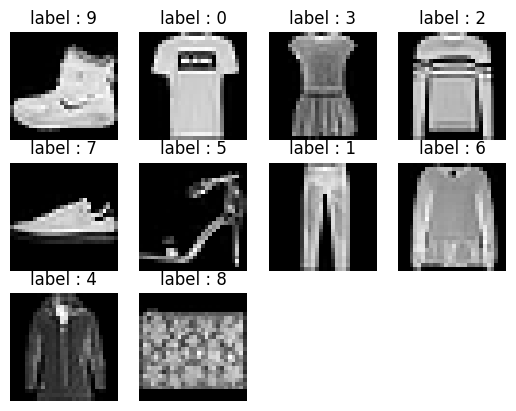

In [7]:
# 각 라벨별 이미지 확인
list = []
for i in range(50):
    one_image, label = raw_train_data[i] #train 이미지에서 하나씩 선택 
    
    if list == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: # 종류별로 하나씩 모두 출력했는지를 확인
        break
        
    if label in list: #이미 출력한 라벨이면 출력 x
        continue

    else:
        list.append(label) #리스트에 인덱스 추가
        list.sort() #비교를 위해 리스트 정렬
        plt.subplot(3, 4, len(list)) #차트 그리기
        plt.axis("off")
        plt.imshow(one_image.squeeze().numpy(), cmap='gray')
        title = "label : " + str(label)
        plt.title(title)

plt.show() #차트 출력

---
#### 7. 데이터 종류별 개수를 확인합니다.
- 학습 데이터의 개수를 확인하여 차트로 출력합니다.

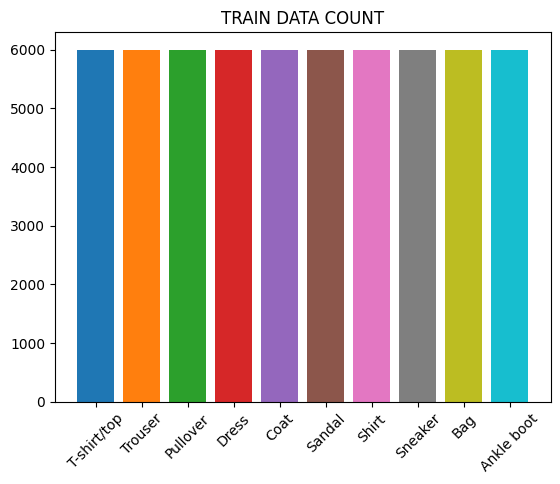

In [8]:
# 각 종류별 데이터 개수 확인
data_count = [0 for i in range(10)] # 개수를 저장할 리스트

for i in range(len(raw_train_data)): #train 데이터를 모두 확인
    img, label = raw_train_data[i] 
    data_count[label] += 1 #각 라벨 위치에 저장

category = {v:k for k,v in raw_train_data.class_to_idx.items()}

plt.title("TRAIN DATA COUNT") #차트 그리기
for i in range(10):
    plt.bar(category.get(i), data_count[i])
    plt.xticks(rotation = 45)

plt.show() #차트 출력

---
#### 8. 모델을 설계합니다.
- `Conv2d` 함수를 통해 컨볼루션 레이어를 만듭니다.

- `MaxPool2d` 함수를 통해 풀링 레이어를 만듭니다.
- `Flatten` 함수를 통해 1차원 행렬로 만듭니다.
- `Linear` 함수를 통해 전결합층 레이어에 넣습니다. 
- `forward(순전파)` 함수에서 Conv2d -> relu -> MaxPool2d -> flatten -> Linear -> log_softmax 의 과정을 거칩니다.
- 모델은 Model 변수에 저장합니다. 모델은 데이터가 있는 곳에서 진행되어야 합니다.
- `summary` 함수를 통해 모델에 대해 확인합니다.

In [9]:
#모델 만들기
class cnnmodel(nn.Module):
    #사진 한 장을 처리
    def __init__(self):
        super(cnnmodel, self).__init__()

        # conv2d는 컨볼루션 레이어 생성 함수
        # 기본 사진은 3색 RGB로 있어서 3개의 층이 쌓여있는 것. 그러나 흑백은 1개의 층 밖에 없음
        # in_channels이 1이라는 것은 흑백사진이 입력으로 들어간다는 것을 의미 (3일 경우, 컬러 사진)
        # out_channels이 9라는 것은 1개의 층을 특성별로 나눠 9개의 층으로 바꾼다는 것을 의미 그리고, depth를 의미함
        # 스트라이드가 없으므로 기본 값 1 이는 한 칸씩 움직이는 것을 의미
        # conv를 하면 (24 x 24 x 9)의 결과가 나옴. 
        # 24는 28(이미지 크기) - 5(커널 사이즈) + 1(스트라이드)이고 9는 out_channels
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 9, kernel_size = (5, 5))
        
        # MaxPool2d는 풀링 레이어 생성 함수
        # 풀링 레이어는 사이즈를 줄이는 것 
        # MaxPooling은 가장 큰 수를 유지하면서 사이즈를 줄이는 방식
        # kernel_size을 2로 적용
        # pool을 하면 (12 x 12 x 9)가 나옴
        self.pool = nn.MaxPool2d(kernel_size = 2)
        
        # 3차원 행렬을 1차원 행렬로 변환하는 과정
        # flatten을 하면 1296이 나옴
        self.flatten = nn.Flatten()

        # 전결합층 레이어(fc)에 넣는 과정
        # Linear(입력 레이어 개수, 출력 레이어 개수)
        # 1296인 12 * 12 * 9인 flatten의 결과 값
        self.fc = nn.Linear(1296, 10)

    #순전파 부분
    def forward(self, x):
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)

        #conv 레이어 적용
        x = self.conv(x)
        
        #relu 적용
        x = nn.functional.relu(x)
        
        #plooling 레이어 적용
        x = self.pool(x)

        #flatten 적용
        x = self.flatten(x)

        #확률 계산하는 softmax 적용
        x = nn.functional.log_softmax(self.fc(x), dim = 1)
        return x 

#모델 생성 및 저장
#모델과 데이터를 같은 곳에 올려야 함
model = cnnmodel().to(default_device)

#모델 요약
summary(model, input_size = (1, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
         MaxPool2d-2            [-1, 9, 12, 12]               0
           Flatten-3                 [-1, 1296]               0
            Linear-4                   [-1, 10]          12,970
Total params: 13,204
Trainable params: 13,204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


---
#### 9. 데이터를 준비합니다.
- `valid` 와 `test` 로 분할했던 데이터들의 이미지와 라벨을 각각 묶어줍니다.

- `DataLoader` 함수를 통해 배치사이즈를 작해 만들어줍니다. 

In [10]:
#분할한 데이터 묶어주기
valid_data = TensorDataset(valid_img, valid_label)
test_data = TensorDataset(test_img, test_label)

# train, valid, test 각각 배치 사이즈 128로 로드
train_loader = torch.utils.data.DataLoader(dataset = raw_train_data, batch_size = 128, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size = 128, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 128, shuffle = False)

---
#### 10. 옵티마이저와 손실 함수를 정의합니다.
- 옵티마이저는 `optim.Adam` 을 사용합니다.

- 손실함수는 `CrossEntropyLoss` 를 사용합니다.

In [11]:
# 옵티마이저 선언 (Adam 사용)
# lr은 학습률의 의미
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# 손실함수 선언 (크로스 엔트로피 손실 함수 사용)
criterion = torch.nn.CrossEntropyLoss().to(default_device)

---
#### 11. 학습을 진행합니다.
- 학습은 `epoch` 을 10으로 하여 진행합니다.
- 학습은 이미지와 모델이 있는 곳에서 진행합니다. 
- 학습을 진행하며 평가도 진행합니다.
- 중간 중간 결과를 저장합니다. 
- epoch 별로 중간 결과도 출력합니다.
- 학습은 `train_data` 를 사용하고, 평가는 `valid_data` 를 사용합니다.

- 중간 결과를 통해 train 정확도가 높아지는 것을 확인할 수 있습니다.

In [12]:
#학습 진행

#10번 학습을 진행 
epochs = 10

history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(default_device), target.to(default_device)
        
        #역전파시 간섭을 막기 위해 zero 초기화
        optimizer.zero_grad()

        #모델 학습 결과
        predict = model(data).to(default_device)

        #모델 학습 결과가 없을 경우
        if predict is None:
            print("모델 실행 결과가 없습니다.")
            continue

        #손실 계산
        loss = criterion(predict, target) 
        
        #손실 계산 값이 없을 경우
        if loss is None:
            print("손실 계산 결과가 없습니다.")
            continue

        #역전파
        loss.backward()

        #단일 optimization step을 수행하고 파라미터 업데이트
        optimizer.step()

        #손실과 정확도 중간 저장
        train_loss += loss.item()
        _, predicted = torch.max(predict.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    #모델 평가 진행
    model.eval()
    valid_loss, valid_correct, valid_total = 0, 0, 0
    
    with torch.no_grad():
        #for data, target in valid_loader:
        for data, target in valid_loader:
            data, target = data.to(default_device), target.to(default_device)

            #평가 결과 
            output = model(data).to(default_device)

            #평가 결과가 없을 경우
            if output is None:
                print("모델 평가에 대한 실행 결과가 없습니다.")
                continue

            #손실 계산
            loss = criterion(output, target)

            #손실 계산 값이 없을 경우
            if loss is None:
                print("모델 평가에 대한 손실 계산 결과가 없습니다.")
                continue

            #손실과 정확도 저장
            valid_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            valid_total += target.size(0)
            valid_correct += (predicted == target).sum().item()
    
    valid_loss /= len(valid_loader.dataset)
    valid_acc = 100. * valid_correct / valid_total
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    
    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

Epoch 1/10: Train Loss: 0.0048, Train Acc: 78.90%, Valid Loss: 0.0039, Valid Acc: 82.24%
Epoch 2/10: Train Loss: 0.0033, Train Acc: 85.42%, Valid Loss: 0.0034, Valid Acc: 84.88%
Epoch 3/10: Train Loss: 0.0030, Train Acc: 86.72%, Valid Loss: 0.0031, Valid Acc: 86.20%
Epoch 4/10: Train Loss: 0.0028, Train Acc: 87.41%, Valid Loss: 0.0029, Valid Acc: 87.08%
Epoch 5/10: Train Loss: 0.0027, Train Acc: 87.99%, Valid Loss: 0.0028, Valid Acc: 87.26%
Epoch 6/10: Train Loss: 0.0026, Train Acc: 88.34%, Valid Loss: 0.0028, Valid Acc: 87.66%
Epoch 7/10: Train Loss: 0.0025, Train Acc: 88.81%, Valid Loss: 0.0027, Valid Acc: 88.02%
Epoch 8/10: Train Loss: 0.0025, Train Acc: 89.09%, Valid Loss: 0.0027, Valid Acc: 88.10%
Epoch 9/10: Train Loss: 0.0024, Train Acc: 89.34%, Valid Loss: 0.0026, Valid Acc: 88.52%
Epoch 10/10: Train Loss: 0.0023, Train Acc: 89.58%, Valid Loss: 0.0026, Valid Acc: 88.02%


---
#### 12. 학습 결과에 대한 결과를 시각화하여 나타냅니다.
- `Loss` 와 `Acc` 로 나누어 확인합니다. 

- `Loss` 는 손실값을 의미하며, `Acc` 는 정확도를 의미합니다.
- `train_data` 와 `valid_data` 를 사용합니다.
- train 그래프를 통해 학습이 진행될 수록 `Loss(손실값)는 낮아지고`, `Acc(정확도)는 높아지는 것`을 볼 수 있습니다.

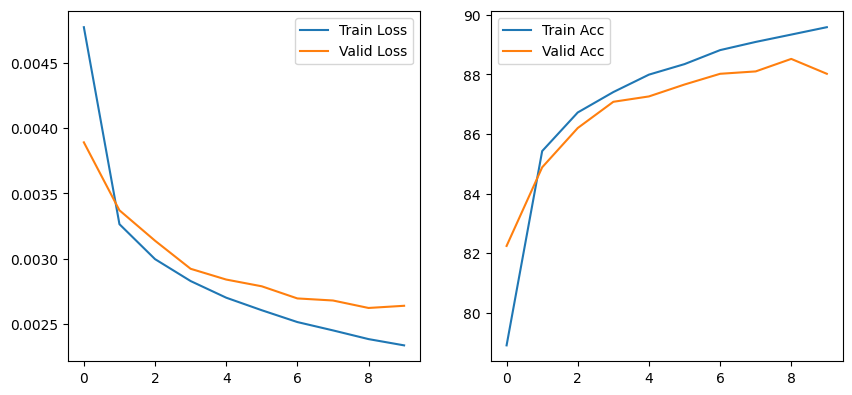

In [13]:
#차트 가로 세로 길이
plt.figure(figsize = (10, 10))

#Loss 그래프 그리기
plt.subplot(221)
plt.plot(history.get('train_loss'), label = "Train Loss")
plt.plot(history.get('valid_loss'), label = "Valid Loss")
plt.legend()

#Acc 그래프 그리기
plt.subplot(222)
plt.plot(history.get('train_acc'), label = "Train Acc")
plt.plot(history.get('valid_acc'), label = "Valid Acc")
plt.legend()

plt.show() #그래프 출력

---
#### 13. 최종 평가를 진행합니다.
- 평가는 모델과 데이터가 있는 곳에서 진행합니다. 

- `Loss` 값과 `Acc` 를 계산합니다.
- 결과를 통해 정확도가 88%로 높게 나온 것을 볼 수 있습니다.

In [14]:
#test 데이터로 최종 평가
model.eval()
X_test, y_test = test_img.to(default_device), test_label.to(default_device)
test_result = model(X_test)

#Loss 값 계산
loss = criterion(test_result, y_test)

#정확도 계산
_, pred = torch.max(test_result.data, 1)
accuracy = 100.*(pred == y_test).sum().item() / len(pred)

#결과 출력
print(f"Test Loss : {loss.item():.9f}")
print(f"Test Acc : {accuracy:5.2f} %")

Test Loss : 0.339652002
Test Acc : 88.30 %


---
#### 14. Sample 데이터를 통해 예측 결과를 확인합니다.
- 이미지 하나를 선택해 출력합니다. 
- 해당 이미지의 예측 값과 정답을 출력합니다. 
- sample 이미지는 잘못 예측한 것으로, 정답은 `Shirt` 이지만 `Pullover` 로 예측했습니다.

테스트 결과
예측 : Pullover
정답 : Shirt


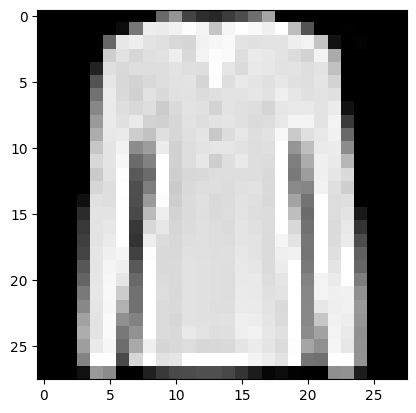

In [15]:
#예측 결과 보기
print("테스트 결과")

plt.imshow(result_test_img.squeeze().numpy(), cmap = 'gray')

pred_index = int(str(pred[0]).split("(")[1].split(")")[0])
label_index = int(str(y_test[0]).split("(")[1].split(")")[0])

print("예측 : " + category.get(pred_index))
print("정답 : " + category.get(label_index))


---
#### 15. 예측 결과에 대한 통계를 확인합니다.
- 전체 테스트 데이터의 개수를 확인합니다. 

- 결과를 확인하며 맞게 예측한 데이터의 수와 잘못 예측한 데이터의 수를 출력합니다.
- 전체 데이터 `5,000개` 중 맞게 예측한 데이터는 `4,415개` 로 대부분 맞게 예측한 것을 볼 수 있었습니다.

In [16]:
correct, wrong = 0, 0

for i in range(len(pred)): #전체 결과를 확인하며 카운트 진행
    pred_index = int(str(pred[0]).split("(")[1].split(")")[0])

    if pred[i] == y_test[i]: #맞게 예측했을 경우 correct + 1
        correct += 1
    else: #잘못 예측했을 경우 wrong + 1
        wrong += 1

print("테스트 데이터의 수 : " + str(correct + wrong)) #전체 테스트 데이터의 개수 
print("맞게 예측한 데이터의 수 : " + str(correct)) #맞게 예측한 데이터의 개수
print("잘못 예측한 데이터의 수 : " + str(wrong)) #잘못 예측한 데이터의 개수


테스트 데이터의 수 : 5000
맞게 예측한 데이터의 수 : 4415
잘못 예측한 데이터의 수 : 585


---
#### 16. 예측 결과를 confusion matrix로 확인합니다.
- y축은 `정답(실제 라벨)` 이며, x축은 `예측 값` 을 의미합니다.

- 대각선의 색이 진하게 출력되는 것을 통해 대부분 맞게 예측했다는 것을 볼 수 있습니다. 
- 해당 숫자는 `예측한 비율` 을 의미합니다.
- 그래프는 seaborn의 heatmap을 통해 출력합니다.
- 해당 그래프를 통해 어떤 것으로 얼만큼 잘못 예측했는지도 알 수 있습니다.
- 또한, 대각선 중에서 가장 색이 옅은 `6번 인덱스` 가 가장 잘못 예측한 것을 알 수 있습니다.

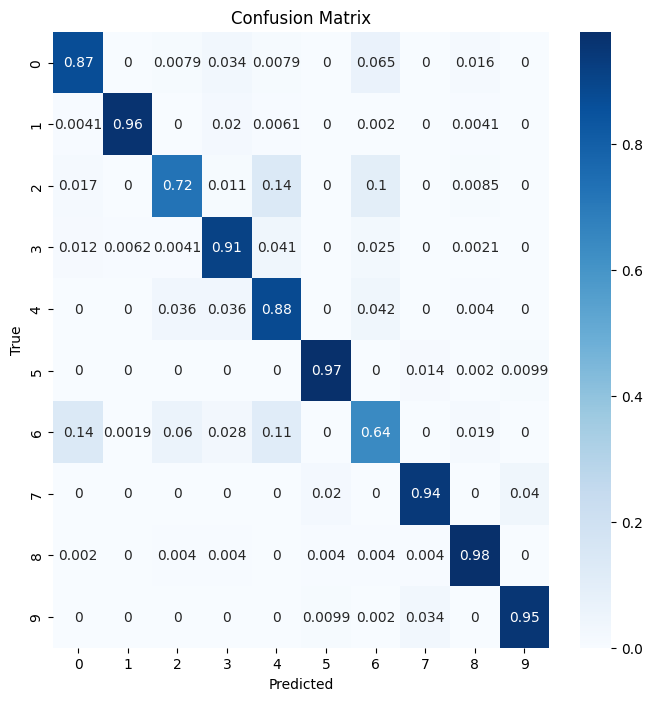

In [17]:
#confusion_matrix로 결과 확인
cm = confusion_matrix(test_label, pred, labels = None, sample_weight = None, normalize = 'true')

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

---
#### 17. 테스트 데이터의 개수를 확인합니다.
- test data는 랜덤 분할을 진행하여, 동일하지 않다는 것을 볼 수 있습니다.

- 가장 많은 데이터를 갖고 있는 것은 `Shirt` 로 `531개` 입니다.
- 가장 적은 데이터를 갖고 있는 것은 `Pullover` 로 `468개` 입니다. 
- 평균 데이터 개수는 `500개` 입니다.

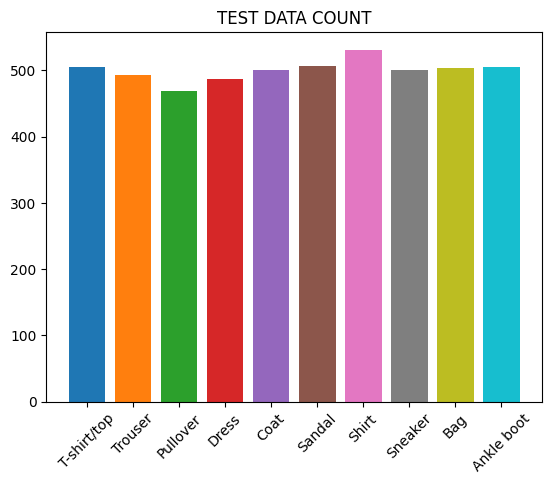

데이터 전체 개수 : [505, 493, 468, 487, 500, 507, 531, 501, 503, 505]
가장 많은 데이터 개수 : 531
가장 적은 데이터 개수 : 468
평균 데이터 개수 : 500


In [18]:
# 테스트 데이터의 각 종류별 데이터 개수 확인
data_count = [0 for i in range(10)] # 개수를 저장할 리스트

for i in range(len(test_data)): #test 데이터를 모두 확인
    img, label = test_data[i] 
    data_count[label] += 1 #각 라벨 위치에 저장

category = {v:k for k,v in raw_train_data.class_to_idx.items()}

plt.title("TEST DATA COUNT") #차트 그리기
for i in range(10):
    plt.bar(category.get(i), data_count[i])
    plt.xticks(rotation = 45)

plt.show() #차트 출력

print("데이터 전체 개수 : " + str(data_count))
print("가장 많은 데이터 개수 : " + str(max(data_count)))
print("가장 적은 데이터 개수 : " + str(min(data_count)))
print("평균 데이터 개수 : " + str(sum(data_count) // len(data_count)))

---
#### 18. 예측 결과를 count 하여 정리합니다.
- 맞게 예측했을 경우, `correct 리스트의 해당 인덱스 값에 +1` 합니다.

- 잘못 예측했을 경우, `wrong 리스트의 정답 인덱스에 +1` 하고, `wrong_result 리스트`에 어떤 것으로 잘못 예측했는지를 확인하기 위해 `예측 값 인덱스에 +1` 합니다. 

In [19]:
#어떤 것으로 잘못 예측했는지 확인
wrong_result = [[0 for j in range(10)] for i in range(10)]

#전체 결과
test_result = {"correct" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] , "wrong" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "wrong_value" : wrong_result}

correct, wrong = 0, 0

for i in range(len(pred)):
    
    pred_index = int(str(pred[i]).split("(")[1].split(")")[0])
    label_index = int(str(test_label[i]).split("(")[1].split(")")[0])

    if pred[i] == test_label[i]:
        test_result['correct'][label_index] += 1 #맞게 예측했을 때 정답-correct에 +1

    else:
        test_result['wrong'][label_index] += 1 #잘못 예측했을 때 정답 - wrong에 +1
        test_result['wrong_value'][label_index][pred_index] += 1 #정답으로 예측한 라벨 카운트 +1

test_result

{'correct': [439, 475, 339, 443, 441, 494, 339, 471, 492, 482],
 'wrong': [66, 18, 129, 44, 59, 13, 192, 30, 11, 23],
 'wrong_value': [[0, 0, 4, 17, 4, 0, 33, 0, 8, 0],
  [2, 0, 0, 10, 3, 0, 1, 0, 2, 0],
  [8, 0, 0, 5, 65, 0, 47, 0, 4, 0],
  [6, 3, 2, 0, 20, 0, 12, 0, 1, 0],
  [0, 0, 18, 18, 0, 0, 21, 0, 2, 0],
  [0, 0, 0, 0, 0, 0, 0, 7, 1, 5],
  [74, 1, 32, 15, 60, 0, 0, 0, 10, 0],
  [0, 0, 0, 0, 0, 10, 0, 0, 0, 20],
  [1, 0, 2, 2, 0, 2, 2, 2, 0, 0],
  [0, 0, 0, 0, 0, 5, 1, 17, 0, 0]]}

---
#### 19. 예측 결과 중 맞게 예측한 것의 결과의 퍼센트를 그래프로 출력합니다.
- `correct_list` 를 사용하여, 그래프를 출력합니다.

- 가장 잘 예측한 종류는 `sneaker` 로 507개 중 `494개` 로 `97%` 맞게 예측했습니다. 
- 가장 잘못 예측한 종류는 `shirt` 로 531개 중 `339개` 로 `63%` 맞게 예측했습니다.

각 데이터의 개수	:  [505, 493, 468, 487, 500, 507, 531, 501, 503, 505]
각 정답 개수	:  [439, 475, 339, 443, 441, 494, 339, 471, 492, 482]


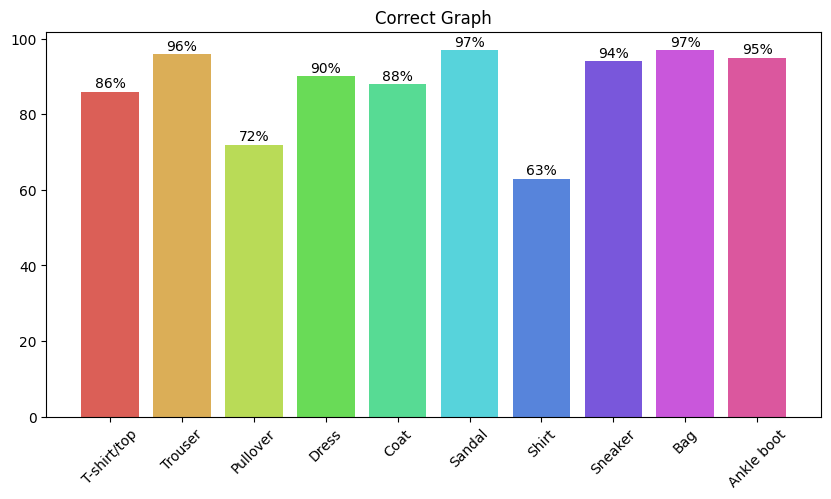

In [20]:
#각 데이터 개수 
print("각 데이터의 개수\t: ", data_count)

#정답 리스트
list = test_result['correct']

#정답 개수
print("각 정답 개수\t: ", list)

#색상 지정 
colors = sns.color_palette('hls',len(list))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Correct Graph')

#비율 계산 리스트 만들기
correct_list = []
for i in range(len(list)):
    correct_list.append(int(list[i] / data_count[i] * 100 // 1))

#차트 그리기
bar = plt.bar(category.values(), correct_list, color = colors)
#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 1, f"{correct_list[i]}%", ha = 'center')

#그래프 출력
plt.show()

---
#### 20. 예측 결과 중 잘못 예측한 것의 결과를 그래프로 출력합니다.
- `wrong_list` 를 사용하여, 그래프를 출력합니다.

- 가장 잘 예측한 종류는 `Bag` 로 503개 중 `11개` 로 `2%`만 잘못 예측했습니다. 
- 가장 잘못 예측한 종류는 `shirt` 로 507개 중 `192개` 로 `36%`를 잘못 예측했습니다.

각 데이터의 개수	:  [505, 493, 468, 487, 500, 507, 531, 501, 503, 505]
각 오답 개수	:  [66, 18, 129, 44, 59, 13, 192, 30, 11, 23]


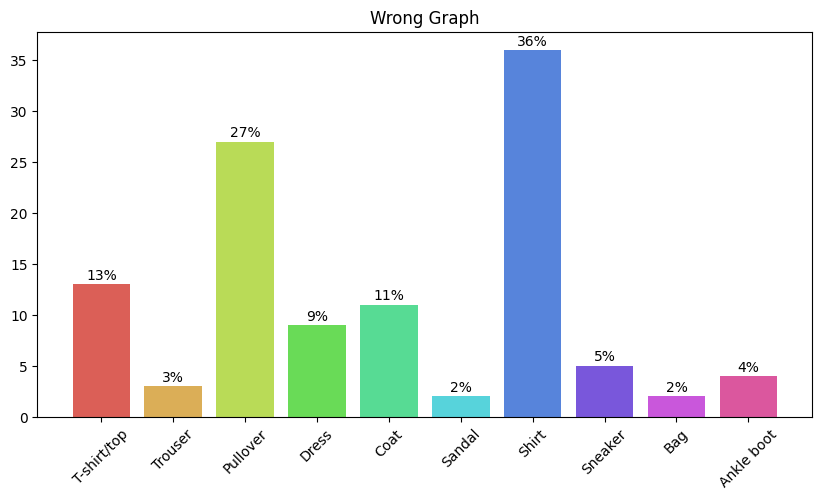

In [21]:
#각 데이터 개수 
print("각 데이터의 개수\t: ", data_count)

#오답 리스트
list = test_result['wrong']

#정답 개수
print("각 오답 개수\t: ", list)

#색상 지정 
colors = sns.color_palette('hls',len(list))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Wrong Graph')

#비율 계산 리스트 만들기
wrong_list = []
for i in range(len(list)):
    wrong_list.append(int(list[i] / data_count[i] * 100 // 1))

#차트 그리기
bar = plt.bar(category.values(), wrong_list, color = colors)
#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 0.5, f"{wrong_list[i]}%", ha = 'center')

#그래프 출력
plt.show()

---
#### 21. 가장 잘못 예측한 종류인 Shirt의 결과를 그래프로 출력합니다.
- `test_result['wrong_value'][6]` 를 사용하여, 그래프를 출력합니다.

- 결과를 통해 Shirt를 `38%`만큼 `T-Shirt/top`로 예측했다는 것을 알 수 있습니다.

Shirt의 잘못 인식한 전체 개수		:  192
Shirt의 잘못 인식한 종류별 개수	:  [74, 1, 32, 15, 60, 0, 0, 0, 10, 0]


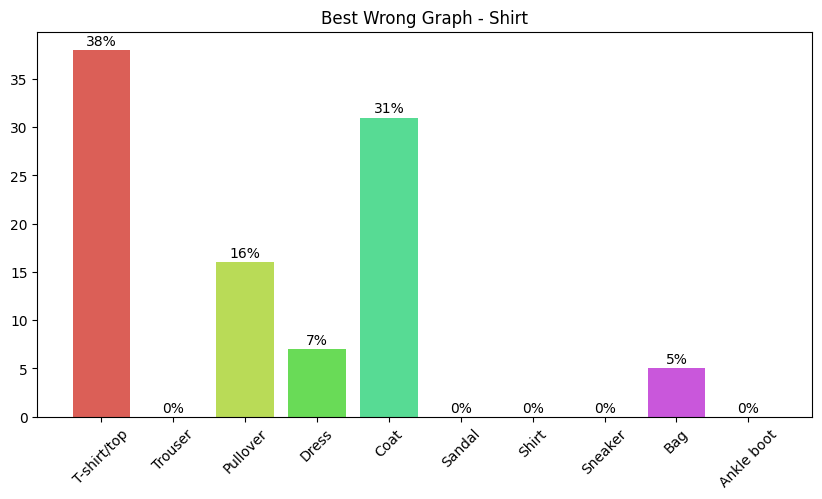

In [22]:
#가장 인식을 잘못한 Shirt에 대한 통계 값
wrong_list = test_result['wrong_value'][6]

#Shirt의 잘못 인식한 개수
print("Shirt의 잘못 인식한 전체 개수\t\t: ", list[6])

#각 데이터 개수 
print("Shirt의 잘못 인식한 종류별 개수\t: ", wrong_list)

#색상 지정 
colors = sns.color_palette('hls',len(correct_list))

best_wrong = []
for i in range(len(wrong_list)):
    best_wrong.append(int(wrong_list[i] / list[6] * 100 // 1))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Best Wrong Graph - Shirt')

#차트 그리기
bar = plt.bar(category.values(), best_wrong, color = colors)

#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 0.5, f"{best_wrong[i]}%", ha = 'center')
    
#그래프 출력
plt.show()

---
#### 22. 잘못 예측한 전체 결과를 그래프로 각각 출력합니다.
- 그래프를 통해 각각을 어떤 것으로 잘못 예측했는지를 알 수 있습니다.

잘못 인식한 전체 개수	:  66
잘못 인식한 종류별 개수	:  [0, 0, 4, 17, 4, 0, 33, 0, 8, 0]


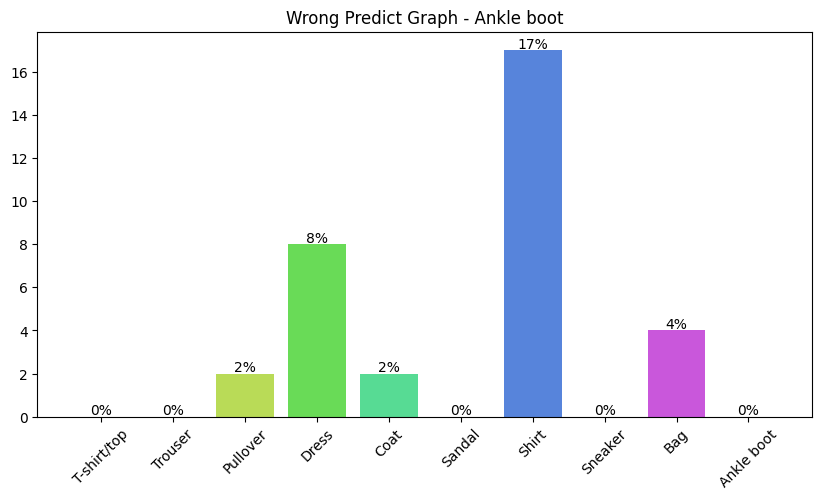

잘못 인식한 전체 개수	:  18
잘못 인식한 종류별 개수	:  [2, 0, 0, 10, 3, 0, 1, 0, 2, 0]


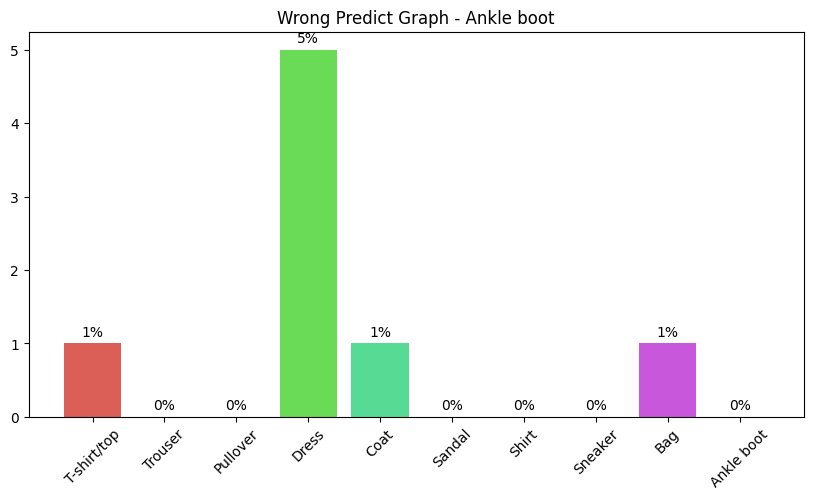

잘못 인식한 전체 개수	:  129
잘못 인식한 종류별 개수	:  [8, 0, 0, 5, 65, 0, 47, 0, 4, 0]


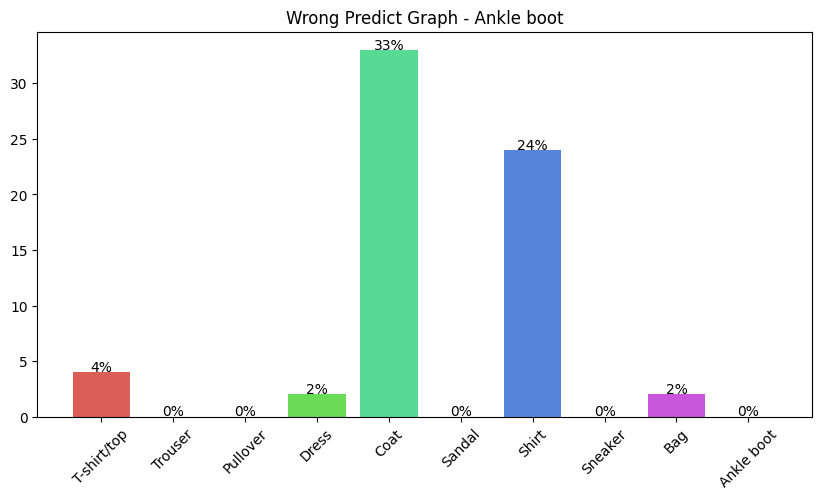

잘못 인식한 전체 개수	:  44
잘못 인식한 종류별 개수	:  [6, 3, 2, 0, 20, 0, 12, 0, 1, 0]


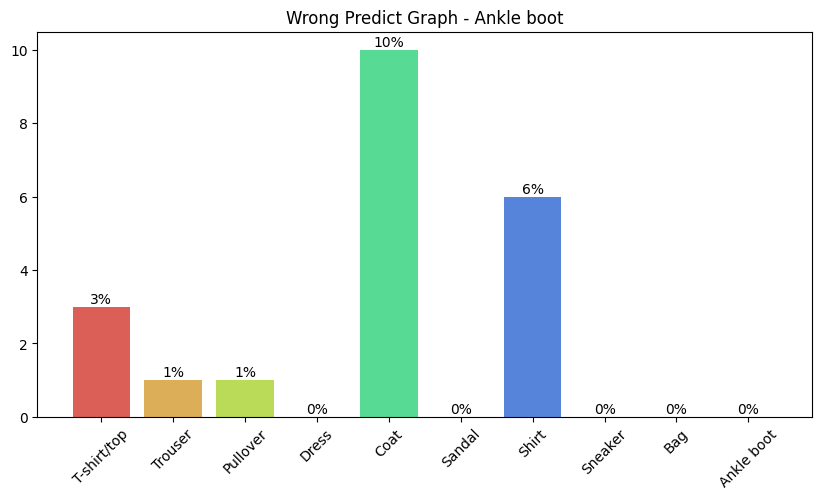

잘못 인식한 전체 개수	:  59
잘못 인식한 종류별 개수	:  [0, 0, 18, 18, 0, 0, 21, 0, 2, 0]


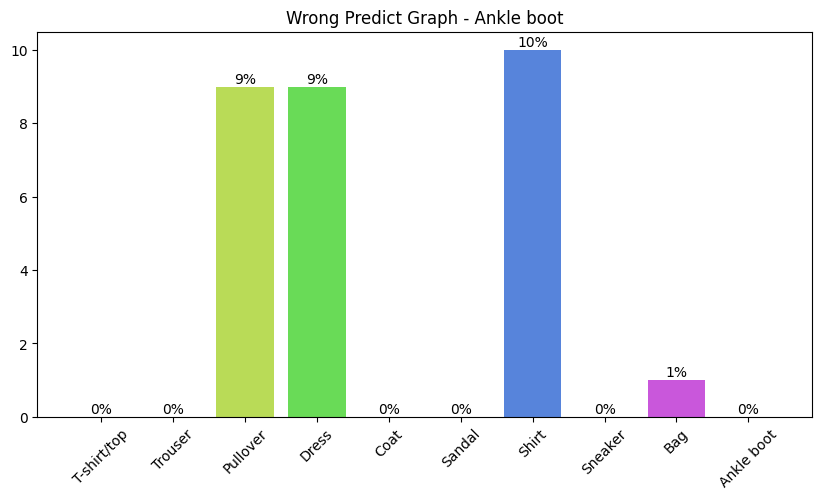

잘못 인식한 전체 개수	:  13
잘못 인식한 종류별 개수	:  [0, 0, 0, 0, 0, 0, 0, 7, 1, 5]


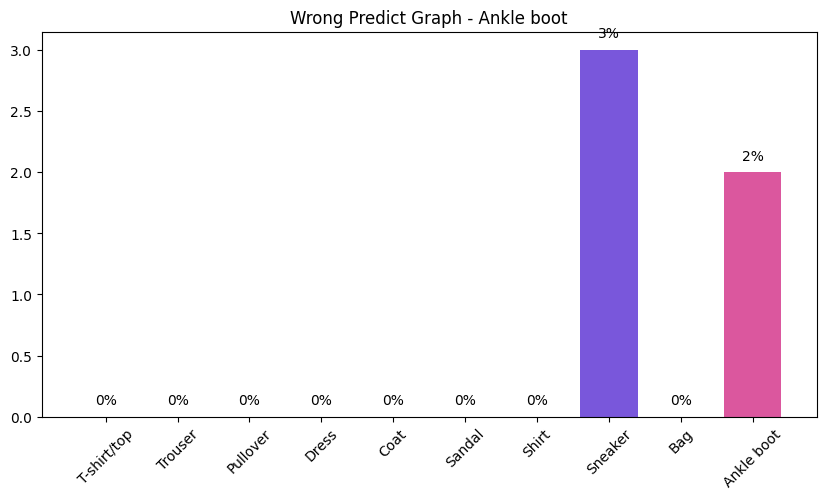

잘못 인식한 전체 개수	:  192
잘못 인식한 종류별 개수	:  [74, 1, 32, 15, 60, 0, 0, 0, 10, 0]


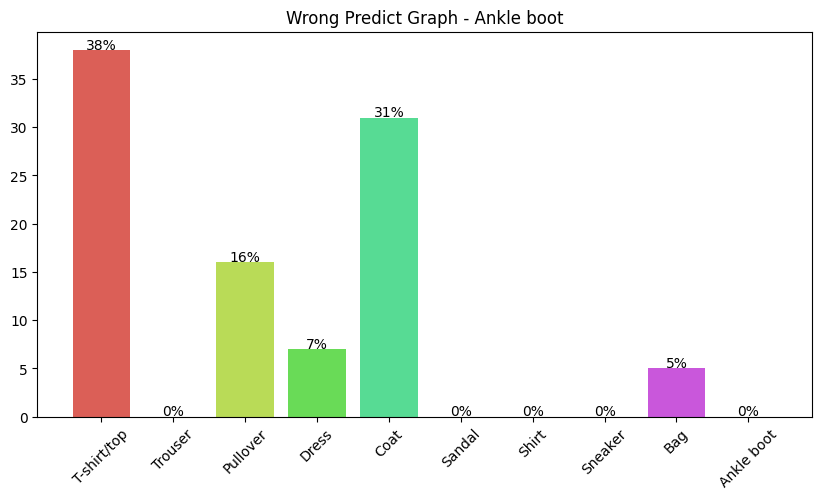

잘못 인식한 전체 개수	:  30
잘못 인식한 종류별 개수	:  [0, 0, 0, 0, 0, 10, 0, 0, 0, 20]


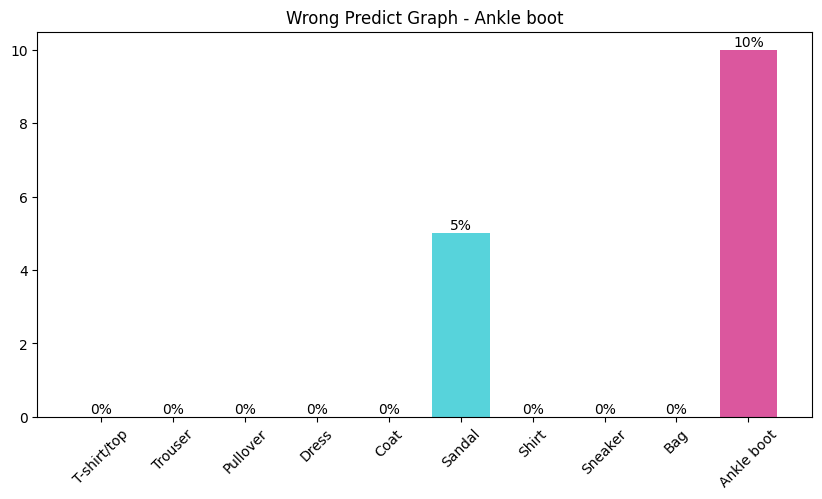

잘못 인식한 전체 개수	:  11
잘못 인식한 종류별 개수	:  [1, 0, 2, 2, 0, 2, 2, 2, 0, 0]


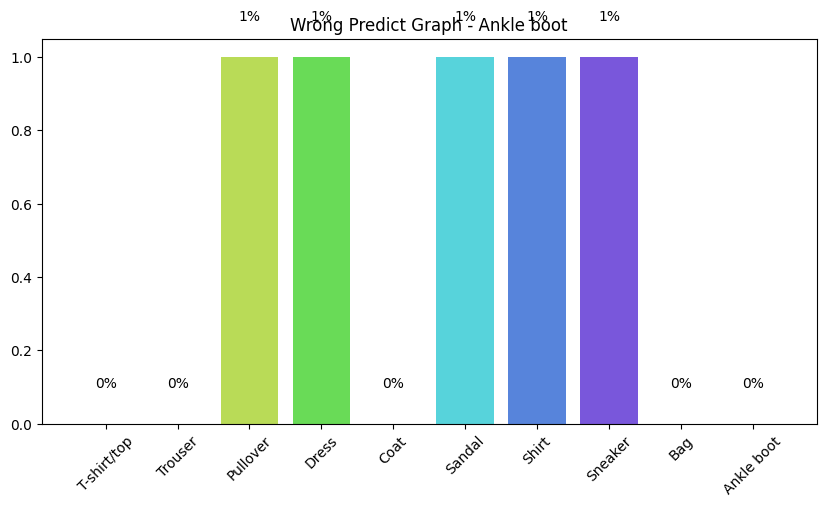

잘못 인식한 전체 개수	:  23
잘못 인식한 종류별 개수	:  [0, 0, 0, 0, 0, 5, 1, 17, 0, 0]


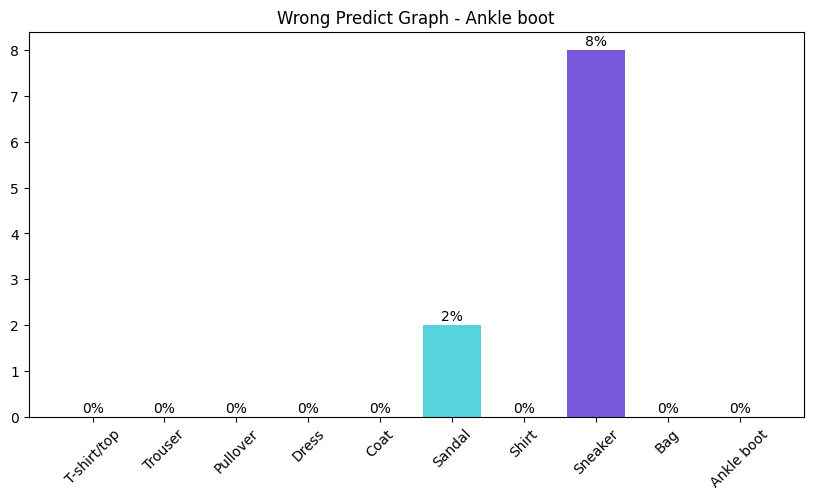

In [23]:
for i in range(10):
    #가장 인식을 잘못한 Shirt에 대한 통계 값
    wrong_list = test_result['wrong_value'][i]

    #Shirt의 잘못 인식한 개수
    print("잘못 인식한 전체 개수\t: ", list[i])

    #각 데이터 개수 
    print("잘못 인식한 종류별 개수\t: ", wrong_list)

    #색상 지정 
    colors = sns.color_palette('hls',len(correct_list))

    best_wrong = []
    for i in range(len(wrong_list)):
        best_wrong.append(int(wrong_list[i] / list[6] * 100 // 1))

    #차트 크기
    plt.figure(figsize = (10, 5))

    #차트 이름
    plt.title('Wrong Predict Graph - ' + category[i])

    #차트 그리기
    bar = plt.bar(category.values(), best_wrong, color = colors)

    #x 라벨 45도 돌리기
    plt.xticks(rotation = 45)

    for i, j in enumerate(bar) :
        plt.text(i, j.get_height() + 0.1, f"{best_wrong[i]}%", ha = 'center')
        
    #그래프 출력
    plt.show()